In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats import pearsonr

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
#all columns except saleprice and id
all_data = pd.concat((train.loc[:, 'MSSubClass':'SaleCondition'],
                        test.loc[:, 'MSSubClass':'SaleCondition']))

array([[<Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'log(price+1)'}>]], dtype=object)

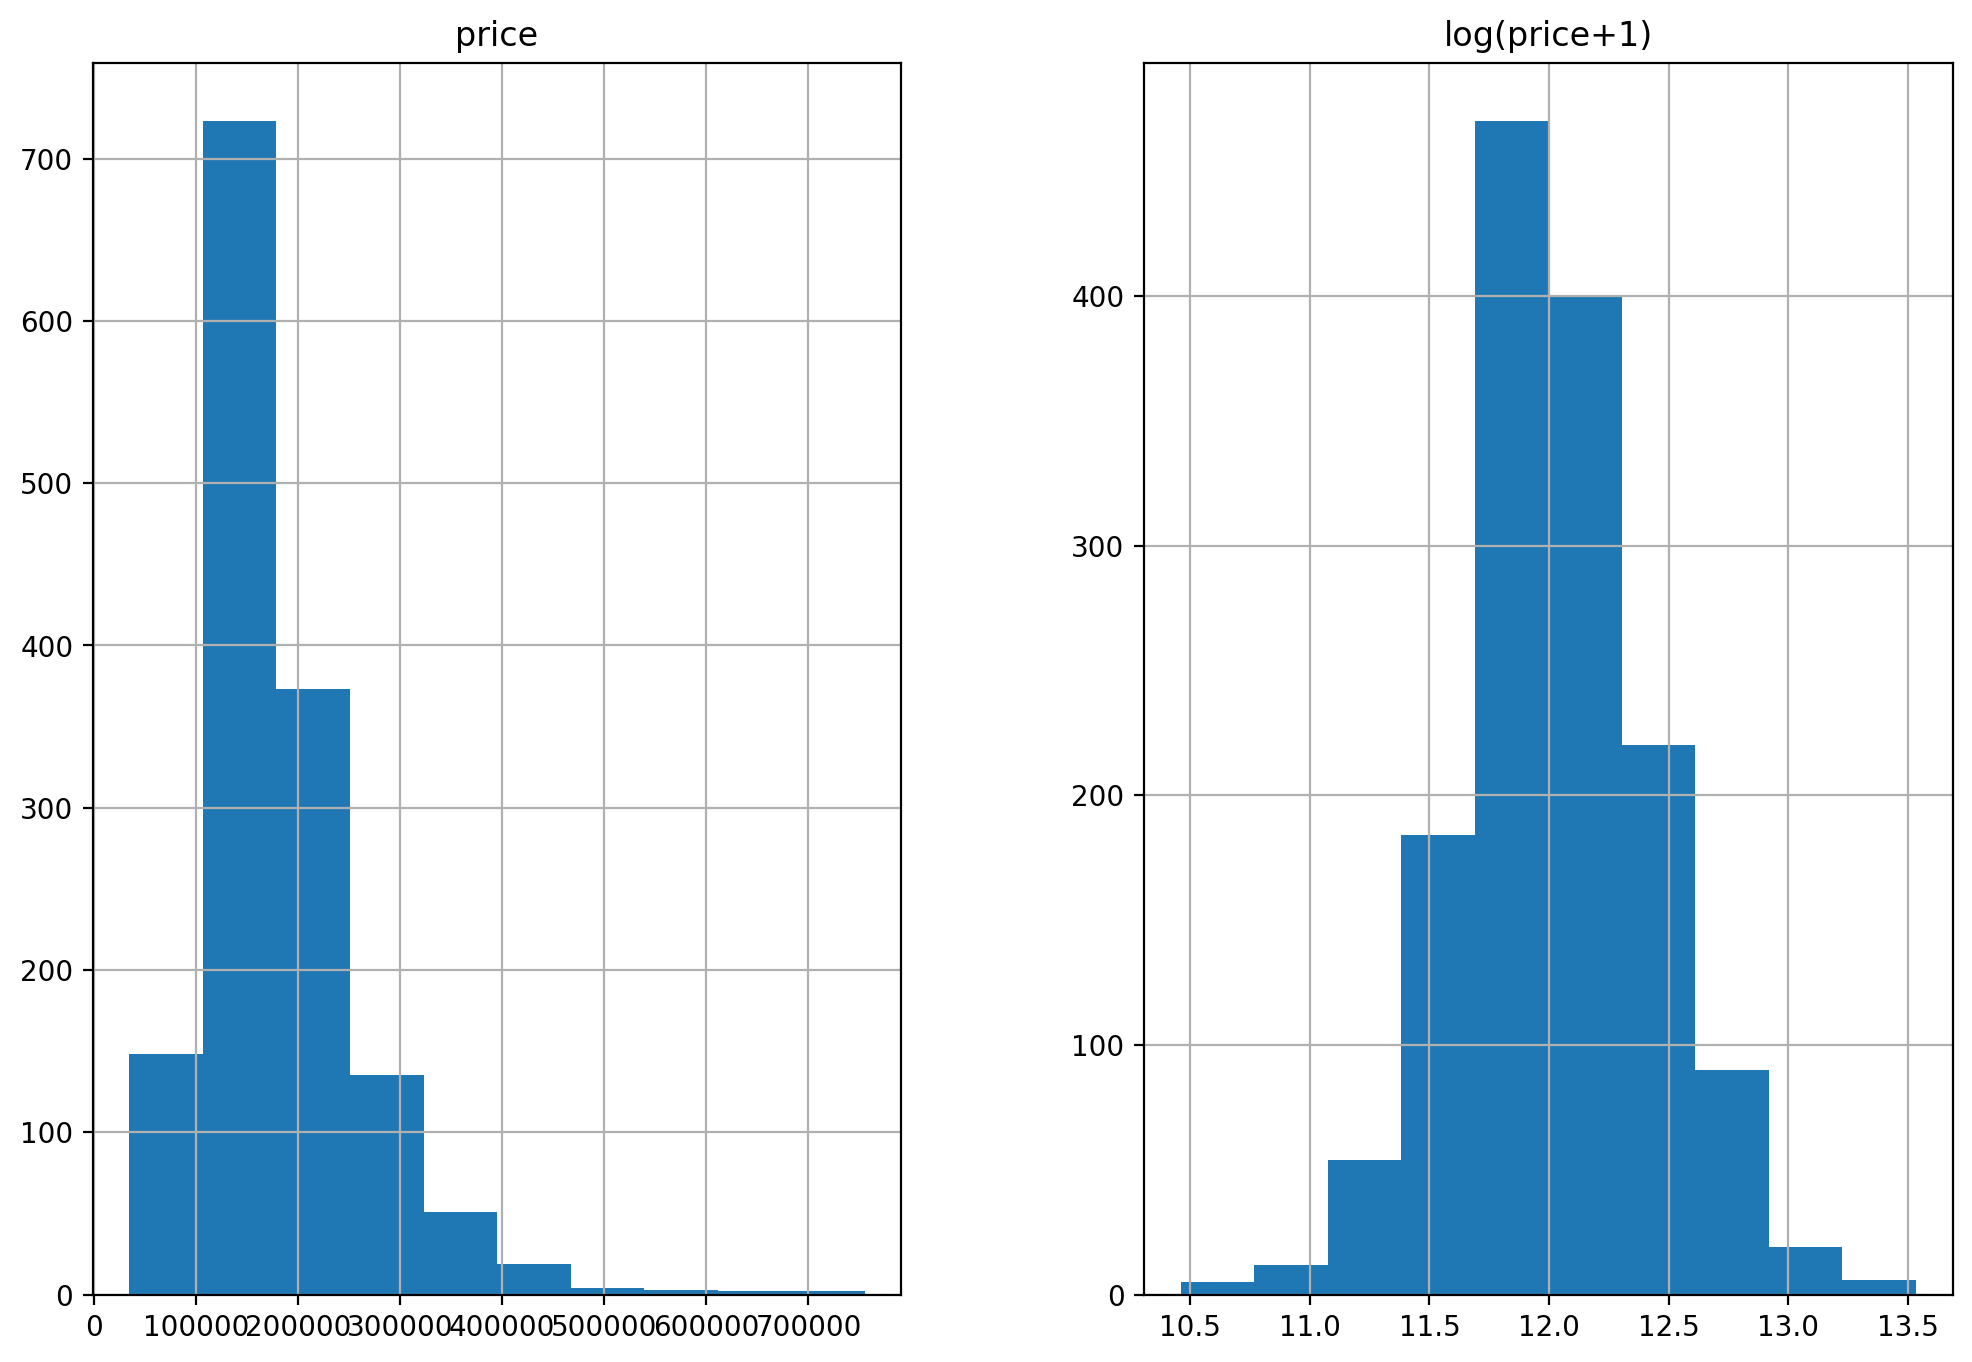

In [5]:
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)
prices = pd.DataFrame({'price': train['SalePrice'], 
                        'log(price+1)': np.log1p(train['SalePrice'])})
prices.hist()

In [6]:
train['SalePrice'] = np.log1p(train['SalePrice'])

numeric_feats = all_data.select_dtypes(include=[np.number])

skewed_feats = numeric_feats.apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [7]:
all_data = pd.get_dummies(all_data)
all_data = all_data.fillna(all_data.mean())

In [8]:
train.shape

(1460, 81)

In [9]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train['SalePrice']

In [10]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv=5))
    return rmse


In [11]:
model_ridge = Ridge()

In [12]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 20, 30, 50, 100]
cv_ridge = [rmse_cv(Ridge(alpha=a)).mean() for a in alphas]

Text(0, 0.5, 'rmse')

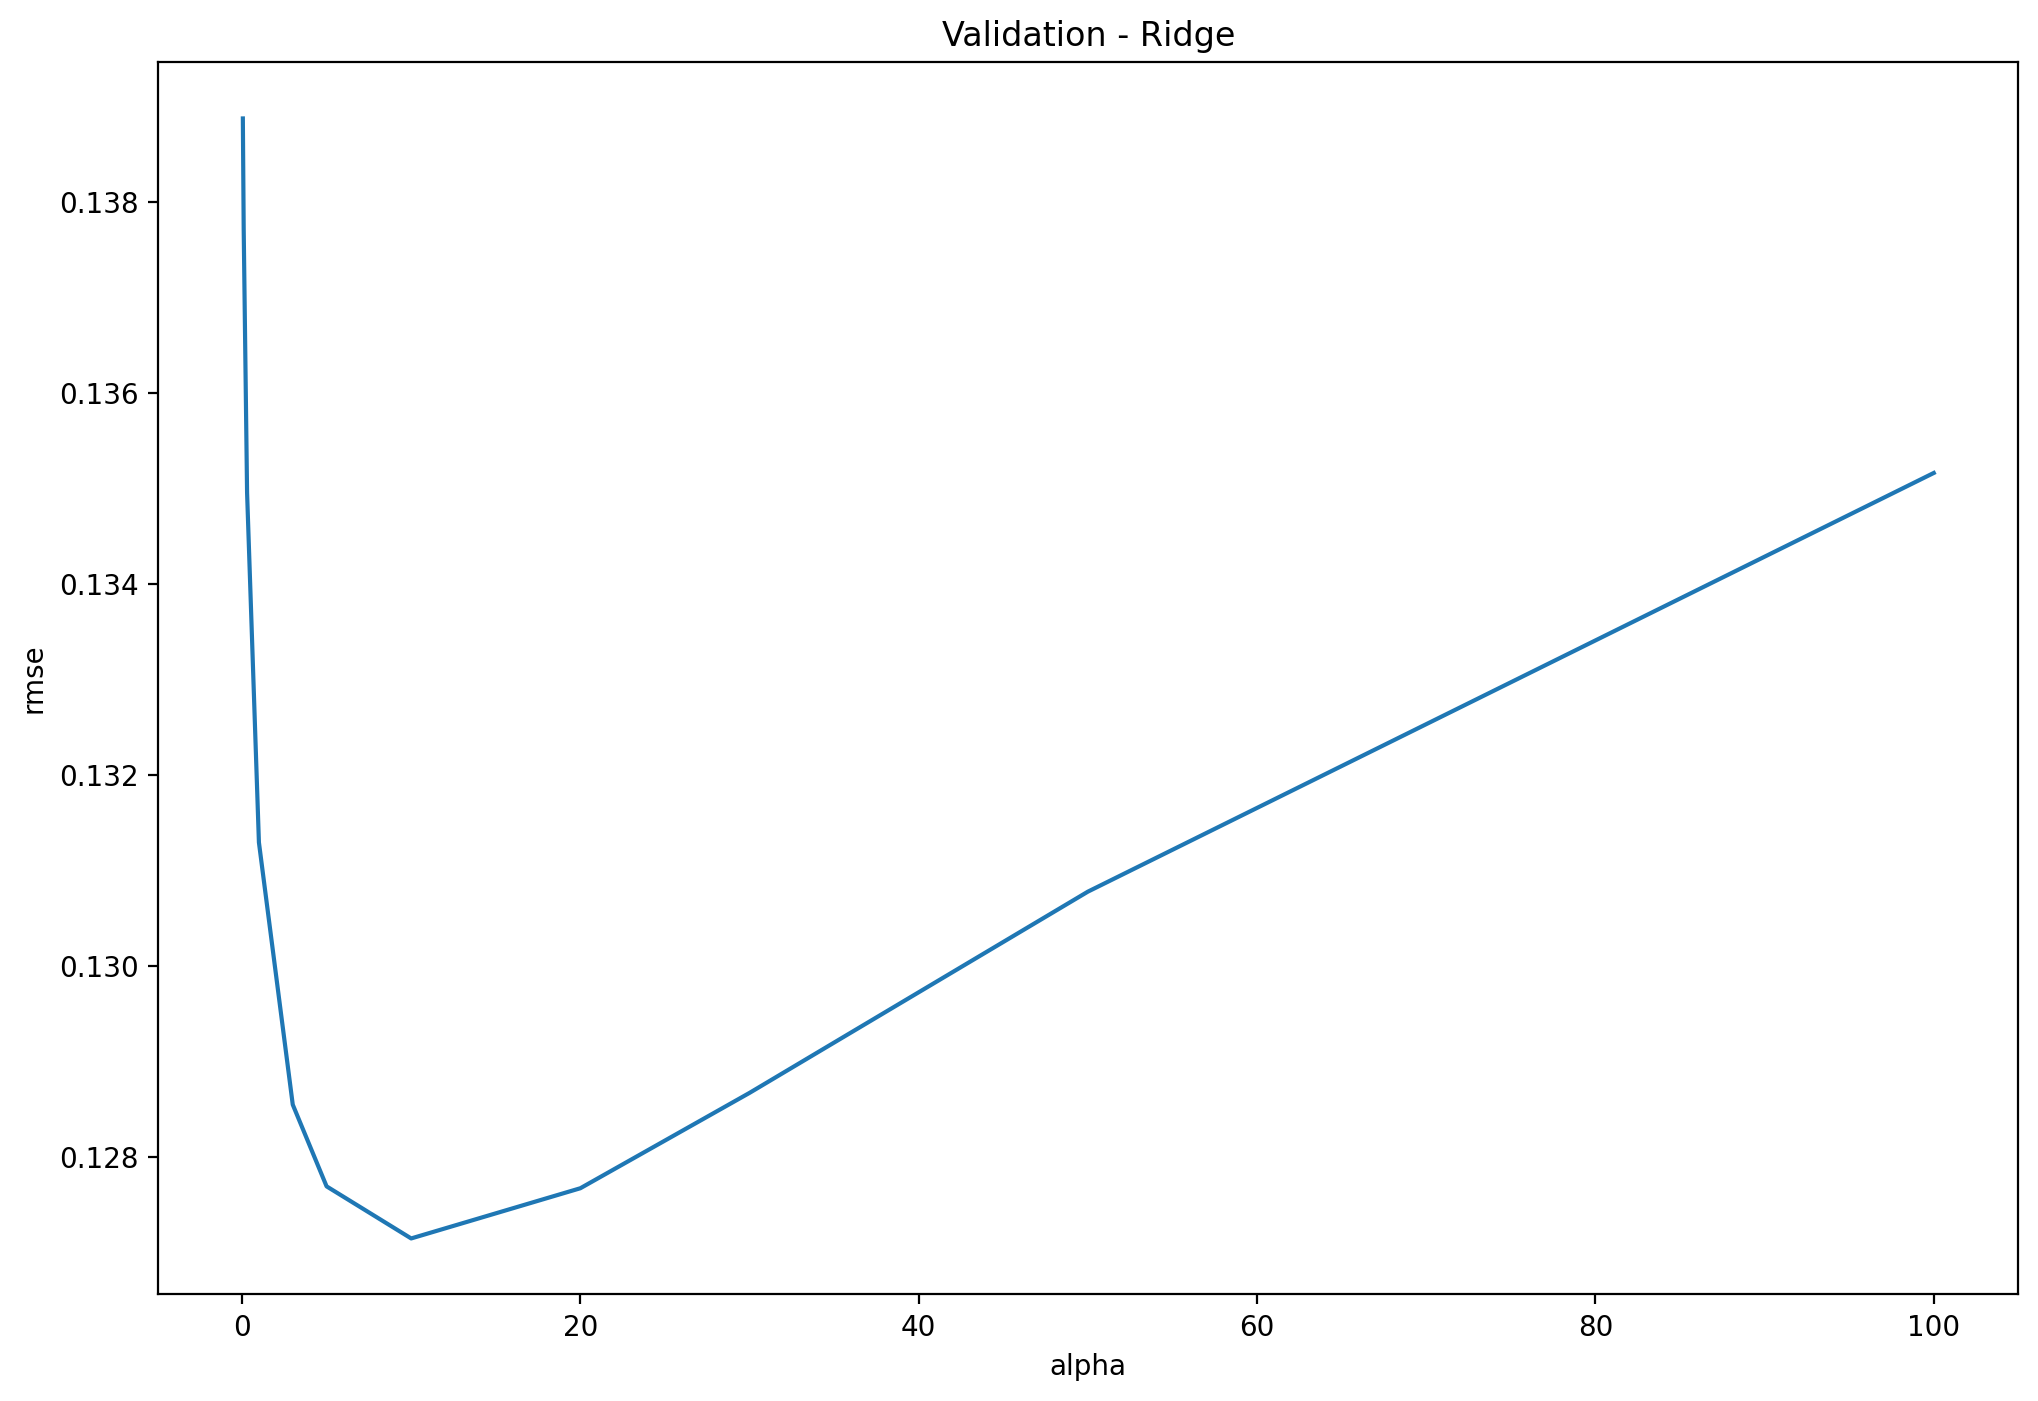

In [13]:
cv_ridge = pd.Series(cv_ridge, index=alphas)
cv_ridge.plot(title='Validation - Ridge')
plt.xlabel('alpha')
plt.ylabel('rmse')

In [14]:
cv_ridge.min()

np.float64(0.12714919049712906)

In [15]:
model_lasso = LassoCV(alphas=[1,0.1,0.001,0.0005]).fit(X_train, y)

In [16]:
rmse_cv(model_lasso).mean()

np.float64(0.12270239544086195)

In [17]:
coef = pd.Series(model_lasso.coef_, index=X_train.columns)

In [18]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " + str(sum(coef == 0)) + " variables")

Lasso picked 109 variables and eliminated the other 178 variables


In [19]:
imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

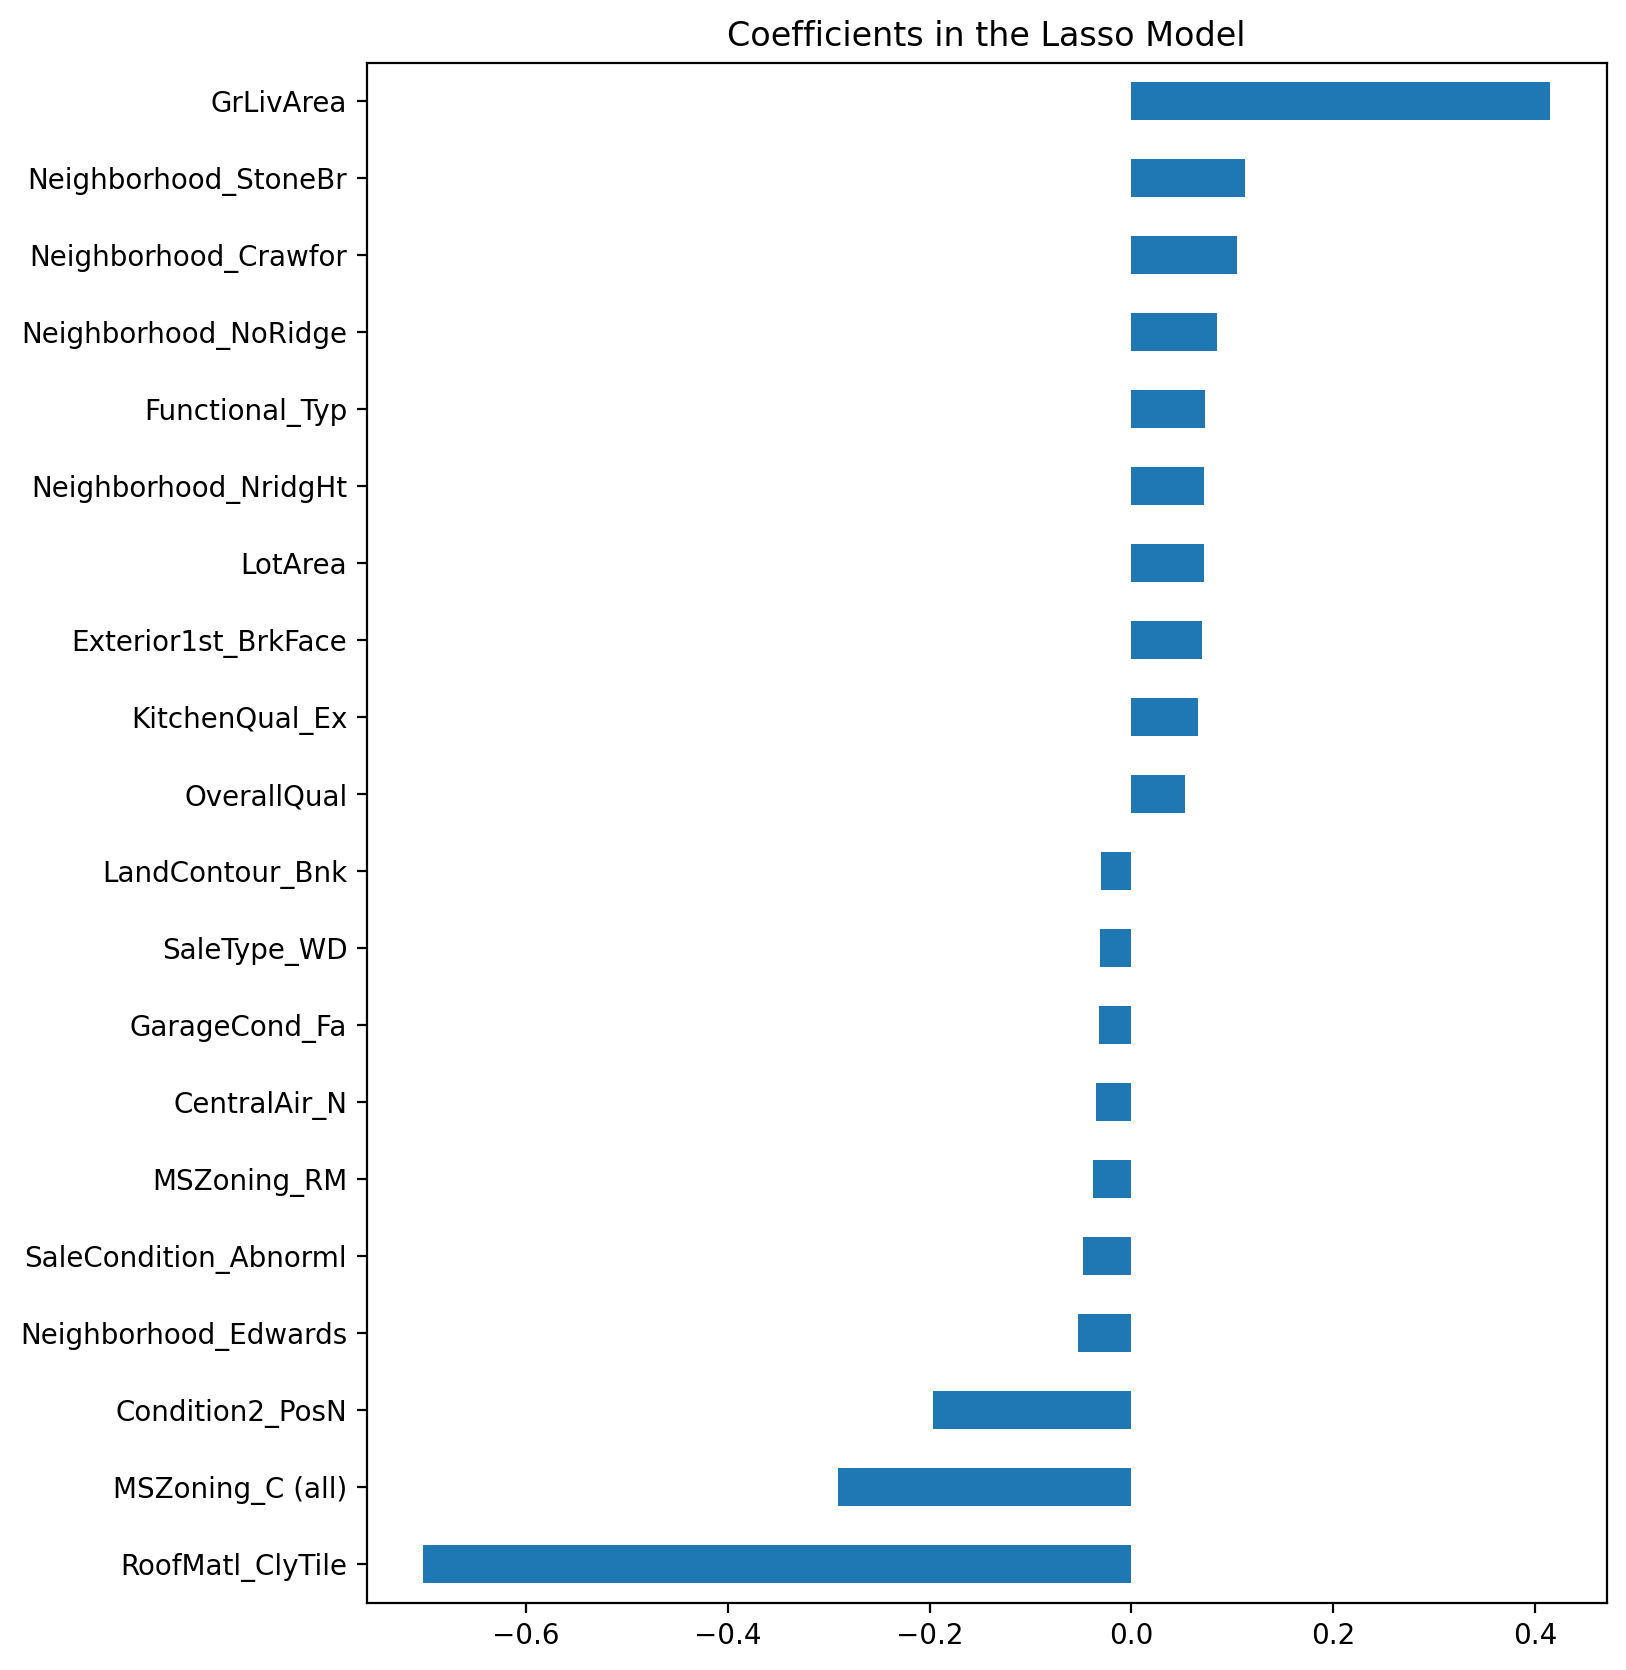

In [20]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind="barh")
plt.title("Coefficients in the Lasso Model")

<Axes: xlabel='preds', ylabel='residuals'>

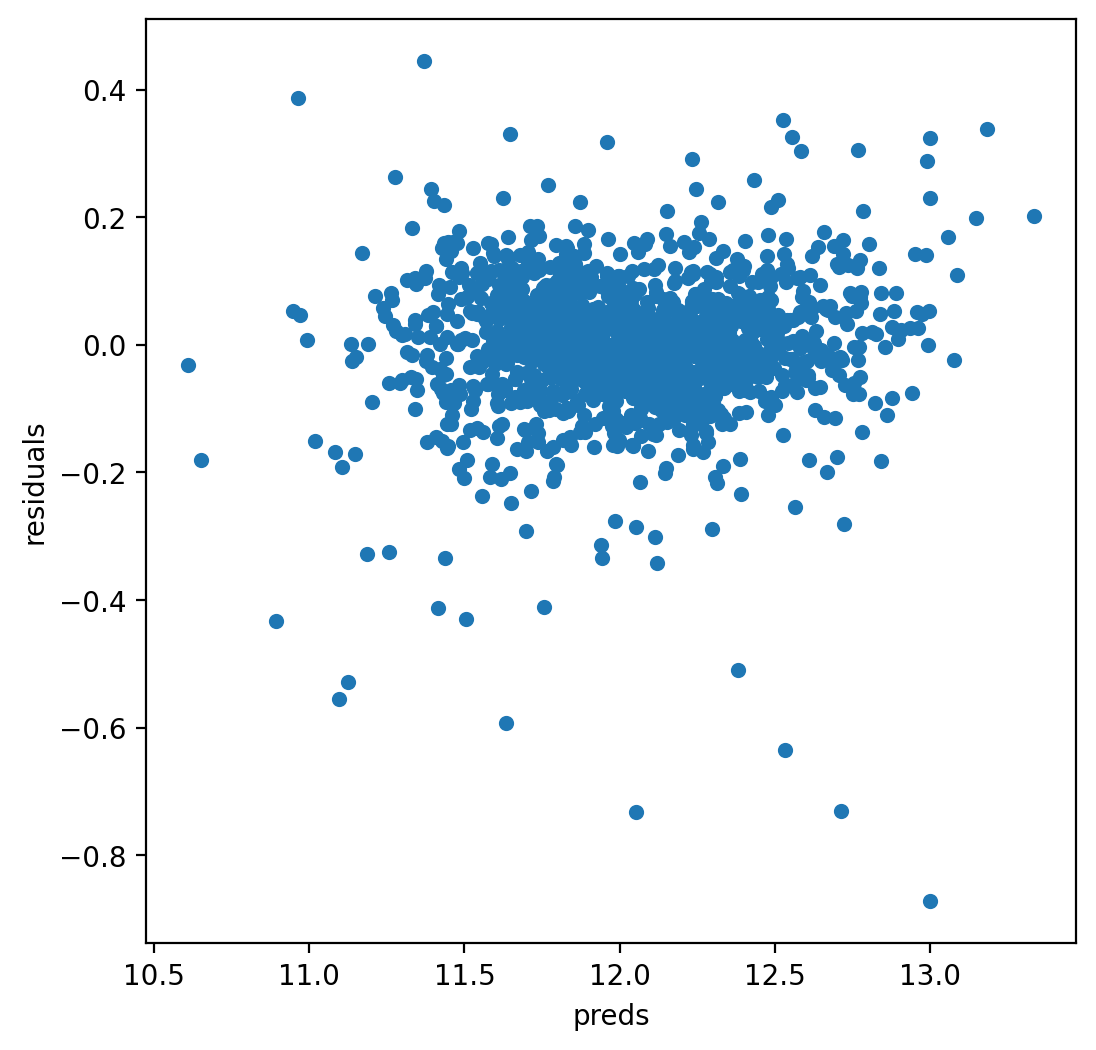

In [21]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({'preds': model_lasso.predict(X_train), 'true':y})
preds['residuals'] = preds['true'] - preds['preds']
preds.plot(x='preds', y='residuals', kind='scatter')

In [22]:
import xgboost as xgb

In [31]:
dtrain = xgb.DMatrix(X_train, label=y)
dtest = xgb.DMatrix(X_test)

params = {'max_depth': 2, 'eta':0.1}
model = xgb.cv(params, dtrain, num_boost_round=1000, early_stopping_rounds=100)

<Axes: title={'center': 'XGBoost RMSE'}>

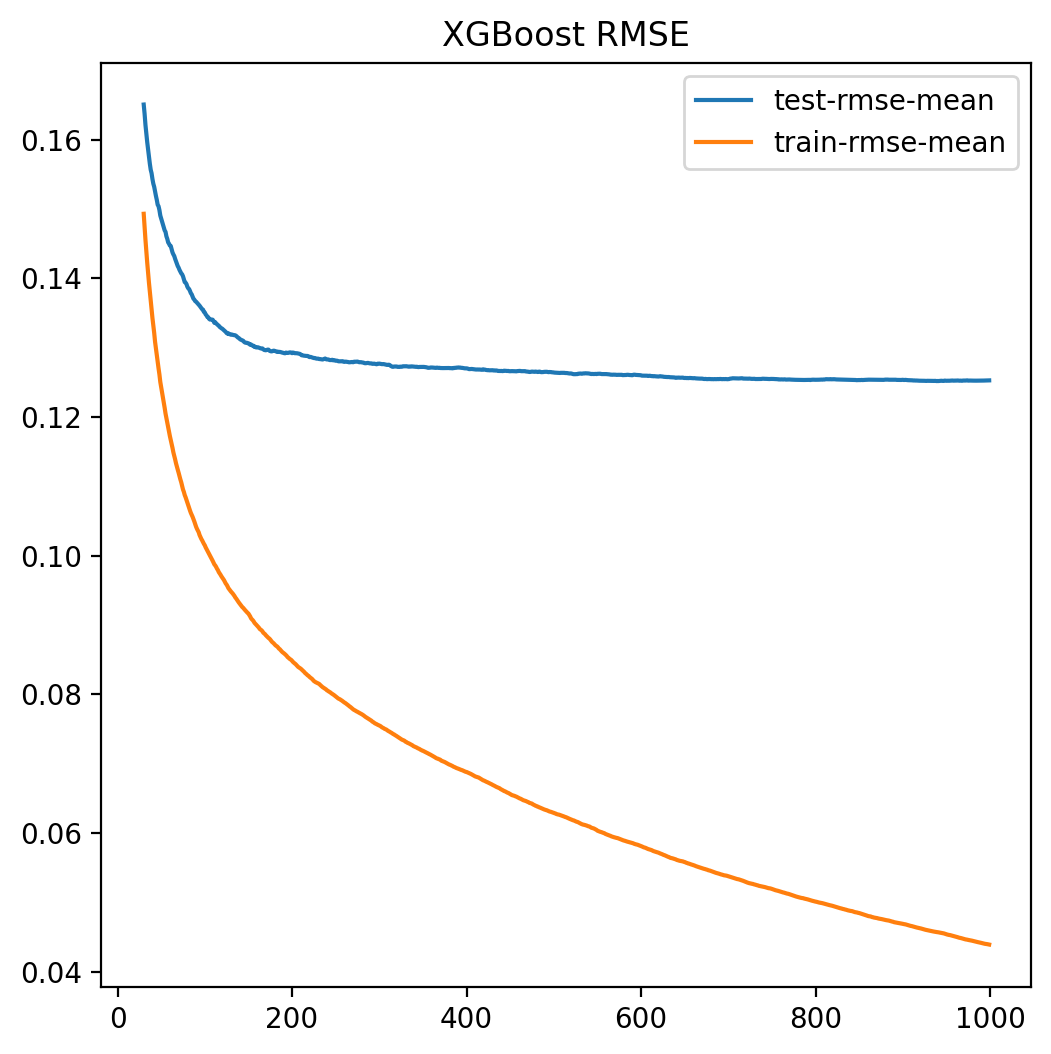

In [33]:
model.loc[30:, ['test-rmse-mean', 'train-rmse-mean']].plot(title='XGBoost RMSE')

In [34]:
model_xgb = xgb.XGBRegressor(n_estimators=200, max_depth=2, learning_rate=0.1)
model_xgb.fit(X_train, y)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [36]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

<Axes: xlabel='xgb', ylabel='lasso'>

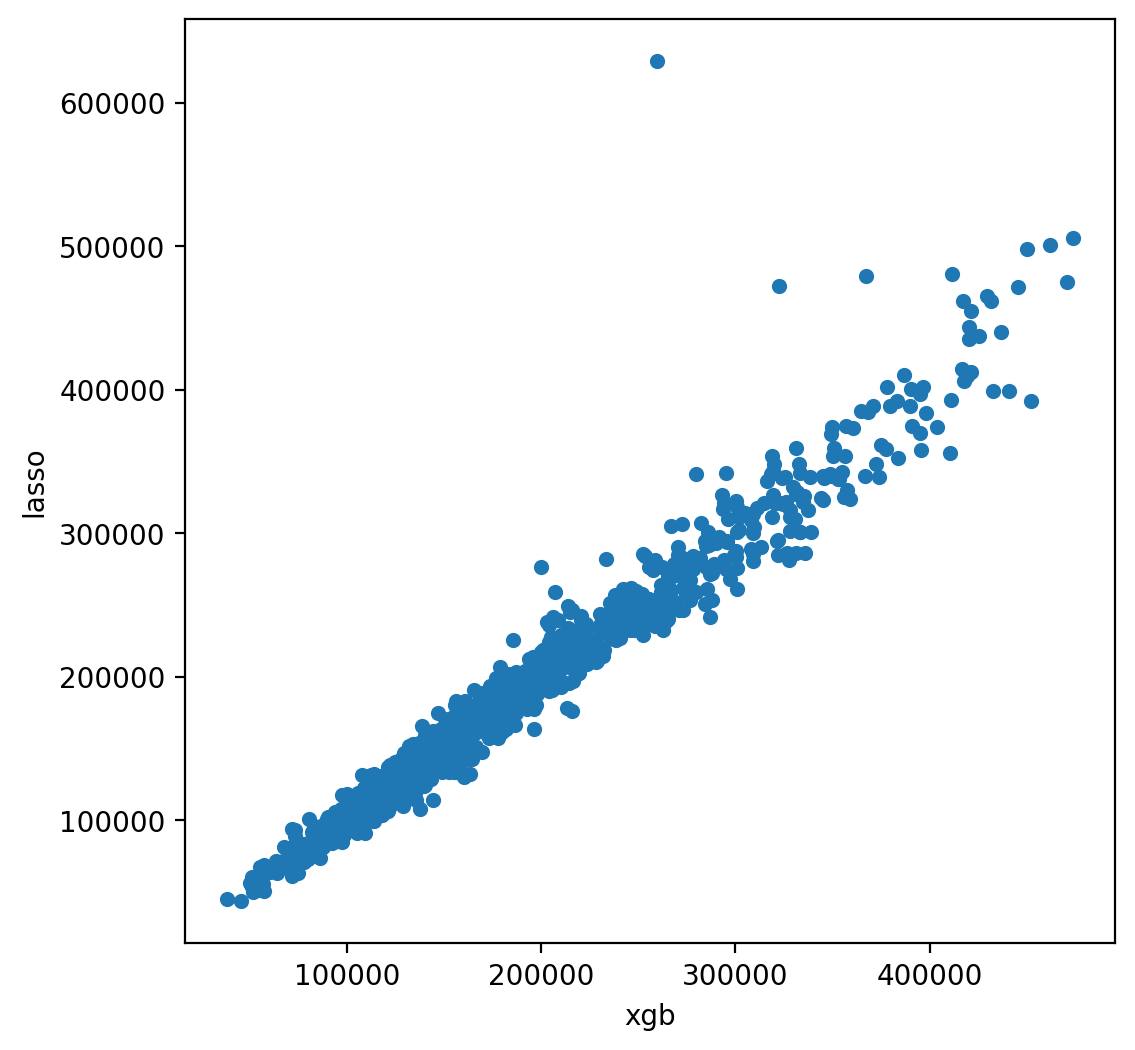

In [37]:
predictions = pd.DataFrame({'xgb': xgb_preds, 'lasso': lasso_preds})
predictions.plot(x='xgb', y='lasso', kind='scatter')

In [38]:
preds = 0.7*lasso_preds + 0.3*xgb_preds

In [39]:
solution = pd.DataFrame({'id': test['Id'], 'SalePrice': preds})
solution.to_csv('submission.csv', index=False)